# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Data-import-and-preprocessing" data-toc-modified-id="Data-import-and-preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data import and preprocessing</a></div><div class="lev1 toc-item"><a href="#Setting-up-data-structures-and-optimization-methods" data-toc-modified-id="Setting-up-data-structures-and-optimization-methods-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setting up data structures and optimization methods</a></div><div class="lev1 toc-item"><a href="#Running-optimization" data-toc-modified-id="Running-optimization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Running optimization</a></div><div class="lev1 toc-item"><a href="#2GP-posterior" data-toc-modified-id="2GP-posterior-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>2GP posterior</a></div><div class="lev1 toc-item"><a href="#Debugging" data-toc-modified-id="Debugging-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Debugging</a></div><div class="lev2 toc-item"><a href="#Constant-shift" data-toc-modified-id="Constant-shift-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Constant shift</a></div>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\V}{\mathbb{V}}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\ones}{\mathbf{1}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \newcommand{\boxleft}{\unicode{x25E7}}
    \newcommand{\boxright}{\unicode{x25E8}}
    \newcommand{\discont}{\unicode{x25EB}}
    \newcommand{\jleft}{\unicode{x21E5}}
    \newcommand{\jright}{\unicode{x21E4}}
    \newcommand{\gp}{\mathcal{GP}}
$$

In this notebook, I follow the path of integrating the linear regression (of the log-prices on the $n \times p$ available covariates stored in model matrix $D$) into the Gaussian Process, by giving each regression parameter a normal prior. This induces a "linear" covariance structure:
\begin{align}
    f &\sim \gp\del{\mu, k(x,x')} \\
    \epsilon &\sim \normal\del{0,\sigma_y^2 I_n} \\
    Y &= D\beta +  f + \epsilon \\
    \beta &\sim \normal\del{0, \sigma_\beta^2 I_p} & \text{so that the distribution of $Y$ becomes}\\
    Y &\sim \normal\del{0, \del{X \sigma_\beta^2 I_p X^\intercal + K(X) + \sigma_y^2 I_n }}
\end{align}
As always, difficulty arises in choosing the hyperparameters $\sigma_y^2$, $\sigma_\beta^2$, and the spatial covariance parameters $\vec\theta$. And as always, we can start with optimizing the marginal likelihood of $Y$ over the hyperparameters.

# Data import and preprocessing

In [1]:
using LaTeXStrings
using GaussianProcesses
using Distributions
using Base.LinAlg
using Distances
import PyPlot; plt=PyPlot
using DataFrames
using GeoJSON
using Optim
using GLM
import MultivariateStats
mvst=MultivariateStats
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in symbol(::String, ::Vararg{String,N}) at ./deprecated.jl:30
 in @glue(::Any) at /Users/imolk/.julia/v0.5/GaussianProcesses/src/GaussianProcesses.jl:22
 in include_from_node1(::String) at ./loading.jl:426
 in eval(::Module, ::Any) at ./boot.jl:234
 in require(::Symbol) at ./loading.jl:357
 in include_string(::String, ::String) at ./loading.jl:380
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/imolk/.julia/v0.5/IJulia/src/execute_request.jl:164
 in eventloop(::ZMQ.Socket) at /Users/imolk/.julia/v0.5/IJulia/src/IJulia.jl:136
 in (::IJulia.##25#31)() at ./task.jl:309
while loading /Users/imolk/.julia/v0.5/GaussianProcesses/src/GaussianProcesses.jl, in expression starting on line 29

Use "Dict(a=>b for (a,b) in c)" instead.


In [2]:
Tucson_sales=readtable("Tucson_data/processed/Tucson_sales.csv", header=true)
# categorical variables
pool!(Tucson_sales, [
    :PropertyType, 
    :SchDistr, 
    :Financing, 
    :ValidationDescription, 
    :BuyerSellerRelated, 
    :Solar,
    :PersonalProperty, 
    :PartialInterest,
    :HEAT,
    :COOL,
    :QUALITY,
    :CLASS,
    :WALLS,
    :ROOF,
    :GARAGE,
    ])
believable = zeros(Bool, size(Tucson_sales,1))
for i in 1:size(Tucson_sales,1)
    if isna(Tucson_sales[i,:BuyerSellerRelated])
        continue
    end
    if Tucson_sales[i,:BuyerSellerRelated]!="No"
        continue
    end
    if isna(Tucson_sales[i,:PartialInterest])
        continue
    end
    if Tucson_sales[i,:PartialInterest]!="No"
        continue
    end
    if isna(Tucson_sales[i,:PropertyType])
        continue
    end
    if !(Tucson_sales[i,:PropertyType] in ("2-4 Plex", "Condo/Townhouse", "Single Family"))
        continue
    end
    if isna(Tucson_sales[i,:ValidationDescription])
        continue
    end
    if !(Tucson_sales[i,:ValidationDescription] in ("Good Sale", "Buyer/Seller has an Out-Of-State Address"))
        continue
    end
    if isna(Tucson_sales[i,:SQFT])
        continue
    end
    believable[i] = true
end

In [3]:
recent = Tucson_sales[:,:SaleDate].>"b'201501"
recent_in_believable = Tucson_sales[believable,:SaleDate].>"b'201501"
Y_dict=Dict{String, Vector{Float64}}()
X_dict=Dict{String, Array{Float64,2}}()
recent_Y_dict=Dict{String, Vector{Float64}}()
recent_X_dict=Dict{String, Array{Float64,2}}()
schdistrs = unique(Tucson_sales[:,:SchDistr])
for name in schdistrs
    Y_dict[name] = log(Tucson_sales[believable & (Tucson_sales[:,:SchDistr] .== name),:SalePrice])
    X_dict[name] =     Tucson_sales[believable & (Tucson_sales[:,:SchDistr] .== name),[:X_PRJ, :Y_PRJ]]'
    recent_Y_dict[name] = log(Tucson_sales[believable & recent & (Tucson_sales[:,:SchDistr] .== name),:SalePrice])
    recent_X_dict[name] =     Tucson_sales[believable & recent & (Tucson_sales[:,:SchDistr] .== name),[:X_PRJ, :Y_PRJ]]'
end
sentinels_json=GeoJSON.parsefile("Tucson_data/processed/SchoolDistrict_borders/SchoolDistrict_sentinels.json")
sentinels=Dict{Tuple{String,String},GeoJSON.MultiPoint}()
for f in sentinels_json.features
    key = (f.properties["SchoolDistrict1"], f.properties["SchoolDistrict2"])
    sentinels[key] = f.geometry
end
sum(recent & believable)

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in transpose(::DataFrames.DataFrame) at ./deprecated.jl:771
 in ctranspose(::DataFrames.DataFrame) at ./operators.jl:300
 in macro expansion; at ./In[3]:10 [inlined]
 in anonymous at ./<missing>:?
 in include_string(::String, ::String) at ./loading.jl:380
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/imolk/.julia/v0.5/IJulia/src/execute_request.jl:164
 in eventloop(::ZMQ.Socket) at /Users/imolk/.julia/v0.5/IJulia/src/IJulia.jl:136
 in (::IJulia.##25#31)() at ./task.jl:309
while loading In[3], in expression starting on line 8


5349

In [4]:
recent_GP_dict=Dict{String, GP}()
σf = 0.2
σy = 0.1
L = 1000.0
kern = SEIso(log(L), log(σf))
for name in schdistrs
    X = recent_X_dict[name]
    Y = recent_Y_dict[name]
    if length(Y)==0
        println("no data for ", name)
        continue
    end
    fit = GP(X', Y, MeanConst(mean(Y)), kern, log(σy))
    recent_GP_dict[name] = fit
end
schdistrs_have = collect(keys(recent_GP_dict))
recent_multiGP = GaussianProcesses.GP[recent_GP_dict[name] for name in schdistrs_have]
;

no data for Tanque Verde Unified District


In [5]:
Tucson_sales[:logSalePrice] = log(Tucson_sales[:SalePrice]);

In [6]:
typealias MultiGP Vector{GP}

Array{GaussianProcesses.GP,1}

In [7]:
nobsv_ = sum([gp.nobsv for gp in recent_multiGP])
for_mm = copy(Tucson_sales[believable & recent,:])
for_mm[:SQFT] =  for_mm[:SQFT] .- mean(for_mm[:SQFT])
for_mm[:SQFT] = for_mm[:SQFT] ./ std(for_mm[:SQFT])
for_mm[:ROOMS] = for_mm[:ROOMS] .- mean(for_mm[:ROOMS])
for_mm[:ROOMS] = for_mm[:ROOMS] ./ std(for_mm[:ROOMS])
for_mm[:STORIES] = for_mm[:STORIES] .- mean(for_mm[:STORIES])
for_mm[:STORIES] = for_mm[:STORIES] ./ std(for_mm[:STORIES])
reordering = collect(1:nobsv_)
istart = 1
for name in schdistrs_have
    indices = find(for_mm[:SchDistr] .== name)
    nobsv_schdistr = length(indices)
    iend = istart+nobsv_schdistr-1
    reordering[istart:iend,:] = indices
    istart = iend+1
end
for_mm = for_mm[reordering,:]
;

In [8]:
contrasts_dict = Dict()
for (term,col) in eachcol(for_mm)
    DataFrames.is_categorical(col) || continue
    contrasts_dict[term] = DataFrames.FullDummyCoding()
end
mf=DataFrames.ModelFrame(logSalePrice ~ SQFT + QUALITY + STORIES + CLASS + ROOF + GARAGE, 
    for_mm, 
    contrasts=contrasts_dict)
mm=ModelMatrix(mf)
p = size(mm,2)
D_=mm.m;

# Setting up data structures and optimization methods

In [9]:
βkern_ = GaussianProcesses.LinIso(log(1.0))

Type: GaussianProcesses.LinIso, Params: [0.0]


In [10]:
type MultiGPCovars{MT<:GaussianProcesses.Mean, KT1<:GaussianProcesses.Kernel, KT2<:GaussianProcesses.Kernel}
    D::Array{Float64,2}
    y::Vector{Float64}
    mgp::MultiGP
    p::Int
    dim::Int
    nobsv::Int
    logNoise::Float64
    m::MT
    k::KT1
    βkern::KT2
    # Auxiliary data
    cK::PDMats.PDMat        # (k + obsNoise)
    alpha::Vector{Float64}  # (k + obsNoise)⁻¹y
    mLL::Float64            # Marginal log-likelihood
    dmLL::Vector{Float64}   # Gradient marginal log-likelihood
    function MultiGPCovars(D::Array{Float64,2}, 
        y::Vector{Float64},
        mgp::MultiGP, 
        p::Int,
        dim::Int,
        nobsv::Int,
        logNoise::Float64,
        m::MT,
        k::KT1,
        βkern::KT2
        )
        mgpcv = new(D, y, mgp, p, dim, nobsv, logNoise, m, k, βkern)
        update_mll!(mgpcv)
        return mgpcv
    end
end

In [11]:
function MultiGPCovars{KT2<:GaussianProcesses.Kernel}(D::Array{Float64,2}, mgp::MultiGP, βkern::KT2)
    nobsv = sum([gp.nobsv for gp in mgp])
    size(D,1) == nobsv || throw(ArgumentError("incompatible dimensions of covariates matrix and gaussian processes"))
    first_gp = mgp[1]
    dim = first_gp.dim
    logNoise = first_gp.logNoise
    k = first_gp.k
    m = first_gp.m
    # harmonize parameters
    for gp in mgp
        gp.k = k
        gp.m = m
        gp.logNoise = logNoise
    end
    p = size(D,2)
    y = vcat([gp.y for gp in recent_multiGP]...)
    mgpcv = MultiGPCovars{typeof(m),typeof(k),KT2}(D, y, mgp, p, dim, nobsv, logNoise, m, k, βkern)
    return mgpcv
end

function propagate_params!(mgpcv::MultiGPCovars)
    for gp in mgpcv.mgp
        # harmonize parameters
        gp.k = mgpcv.k
        gp.m = mgpcv.m
        gp.logNoise = mgpcv.logNoise
    end
end

function grad_stack!(stack::AbstractArray, se::SEIso, X::Matrix{Float64}, data::GaussianProcesses.IsotropicData)
    nobsv = size(X, 2)
    R = data.R
    σ2=se.σ2
    ℓ2=se.ℓ2
    for j in 1:nobsv, i in 1:j
        @inbounds stack[i,j,1] = σ2*R[i,j]/ℓ2*exp(-0.5*R[i,j]/ℓ2) # dK_dℓ
        @inbounds stack[j,i,1] = stack[i,j,1]
end
    for j in 1:nobsv, i in 1:j
        @inbounds stack[i,j,2] = 2.0*σ2*exp(-0.5*R[i,j]/ℓ2)
        @inbounds stack[j,i,2] = stack[i,j,2]
    end

    return stack
end

function distance!(k::GaussianProcesses.Isotropic, X::Matrix{Float64}, data::GaussianProcesses.IsotropicData)
    return data.R
end

function update_mll!(mgpcv::MultiGPCovars, cK::Matrix{Float64})
    propagate_params!(mgpcv)
    ell = exp(mgpcv.βkern.ll)
    Base.LinAlg.BLAS.gemm!('N', 'T', 1/ell^2, mgpcv.D, mgpcv.D, 0.0, cK)
    Base.LinAlg.copytri!(cK, 'U')
    m = Array(Float64, mgpcv.nobsv)
    istart=0
    for gp in mgpcv.mgp
        m[istart+1:istart+gp.nobsv] = mean(mgpcv.m,gp.X)
        R = distance!(mgpcv.k, gp.X, gp.data)
        for j in 1:gp.nobsv
            for i in 1:gp.nobsv
                @inbounds cK[istart+i,istart+j] += cov(mgpcv.k, R[i,j])
            end
        end
        istart += gp.nobsv
    end
    for i in 1:mgpcv.nobsv
        cK[i,i] += max(exp(2*mgpcv.logNoise),1e-8)
    end
    mgpcv.cK = PDMats.PDMat(cK)
    mgpcv.alpha = mgpcv.cK \ (mgpcv.y .- m)
    mgpcv.mLL = -dot((mgpcv.y-m),mgpcv.alpha)/2.0 - logdet(mgpcv.cK)/2.0 - mgpcv.nobsv*log(2π)/2.0
end

function update_mll!(mgpcv::MultiGPCovars)
    cK_buffer = Array(Float64, mgpcv.nobsv, mgpcv.nobsv)
    update_mll!(mgpcv, cK_buffer)
end

update_mll! (generic function with 2 methods)

In [12]:
function update_mll_and_dmll!(mgpcv::MultiGPCovars,
    cK::Matrix{Float64},
    Kgrads::Array{Float64,3}
    ; 
    noise::Bool=true, # include gradient component for the logNoise term
    mean::Bool=true, # include gradient components for the mean parameters
    kern::Bool=true, # include gradient components for the spatial kernel parameters
    beta::Bool=true, # include gradient components for the linear regression prior terms
    )
    update_mll!(mgpcv, cK)
    n_mean_params = GaussianProcesses.num_params(mgpcv.m)
    n_kern_params = GaussianProcesses.num_params(mgpcv.k)
    n_beta_params = GaussianProcesses.num_params(mgpcv.βkern)
    dmLL = Array(Float64, noise + mean*n_mean_params + kern*n_kern_params + beta*n_beta_params)
    logNoise = mgpcv.logNoise
    α = mgpcv.alpha
    ααinvcKI = α*α' - mgpcv.cK \ eye(mgpcv.nobsv)
    i=1
    if noise
        dmLL[i] = exp(2*logNoise)*trace(ααinvcKI)
        i+=1
    end
    if mean
        Mgrads = vcat([GaussianProcesses.grad_stack(gp.m, gp.X) for gp in recent_multiGP]...)
        for j in 1:n_mean_params
            dmLL[i] = dot(Mgrads[:,j],α)
            i+=1
        end
    end
    if kern
        Kgrads[:,:,:] = 0.0
        istart=0
        for j in i:i+n_kern_params-1
            dmLL[j] = 0.0
        end
        for gp in mgpcv.mgp
            Kview = @view(Kgrads[istart+1:istart+gp.nobsv,istart+1:istart+gp.nobsv,1:n_kern_params])
            ααview = @view(ααinvcKI[istart+1:istart+gp.nobsv,istart+1:istart+gp.nobsv])
            GaussianProcesses.grad_stack!(Kview, mgpcv.k, gp.X, gp.data)
            for j in 1:n_kern_params
                dmLL[i+j-1] += sum(ααview.*@view(Kview[:,:,j]))
            end
            istart += gp.nobsv
        end
        for j in 1:n_kern_params
            dmLL[i] /= 2.0
            i+=1
        end
    end
    if beta
        GaussianProcesses.grad_stack!(@view(Kgrads[:,:,1]), mgpcv.βkern, mgpcv.D')
        for j in 1:1
            dmLL[i] = sum(ααinvcKI.*@view(Kgrads[:,:,j]))/2
            i+=1
        end
    end
    mgpcv.dmLL = dmLL
end

update_mll_and_dmll! (generic function with 1 method)

In [13]:
function get_params(mgpcv::MultiGPCovars; noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true)
    params = Float64[]
    if noise; push!(params, mgpcv.logNoise); end
    if mean;  append!(params, GaussianProcesses.get_params(mgpcv.m)); end
    if kern; append!(params,  GaussianProcesses.get_params(mgpcv.k)); end
    if beta; append!(params,  GaussianProcesses.get_params(mgpcv.βkern)); end
    return params
end

get_params (generic function with 1 method)

In [14]:
function set_params!(mgpcv::MultiGPCovars, hyp::Vector{Float64}; 
                    noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true)
    i=1
    if noise
        mgpcv.logNoise = hyp[i]
        i+=1
    end
    if mean
        GaussianProcesses.set_params!(mgpcv.m, hyp[i:i+GaussianProcesses.num_params(mgpcv.m)-1])
        i+=GaussianProcesses.num_params(mgpcv.m)
    end
    if kern
        GaussianProcesses.set_params!(mgpcv.k, hyp[i:i+GaussianProcesses.num_params(mgpcv.k)-1])
        i+=GaussianProcesses.num_params(mgpcv.k)
    end
    if beta
        GaussianProcesses.set_params!(mgpcv.βkern, hyp[i:i+GaussianProcesses.num_params(mgpcv.βkern)-1])
        i+=GaussianProcesses.num_params(mgpcv.βkern)
    end
    propagate_params!(mgpcv)
end

set_params! (generic function with 1 method)

In [15]:
@doc """
# Description
A function for optimising the GP hyperparameters based on type II maximum likelihood estimation. This function performs gradient based optimisation using the Optim pacakge to which the user is referred to for further details.

# Arguments:
* `gp::GP`: Predefined Gaussian process type
* `noise::Bool`: Noise hyperparameters should be optmized
* `mean::Bool`: Mean function hyperparameters should be optmized
* `kern::Bool`: Kernel function hyperparameters should be optmized
* `kwargs`: Keyword arguments for the optimize function from the Optim package
""" ->
function GaussianProcesses.optimize!(mgpcv::MultiGPCovars; noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true, 
                    method=ConjugateGradient(), kwargs...)
    cK_buffer = Array(Float64, mgpcv.nobsv, mgpcv.nobsv)
    Kgrads_buffer = Array(Float64, mgpcv.nobsv, mgpcv.nobsv, 3)
    function mll(hyp::Vector{Float64})
        set_params!(mgpcv, hyp; noise=noise, mean=mean, kern=kern, beta=beta)
        update_mll!(mgpcv, cK_buffer)
        return -mgpcv.mLL
    end
    function dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        set_params!(mgpcv, hyp; noise=noise, mean=mean, kern=kern, beta=beta)
        update_mll_and_dmll!(mgpcv, cK_buffer, Kgrads_buffer; noise=noise, mean=mean, kern=kern, beta=beta)
        grad[:] = -mgpcv.dmLL
    end
    function mll_and_dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        set_params!(mgpcv, hyp; noise=noise, mean=mean, kern=kern, beta=beta)
        update_mll_and_dmll!(mgpcv, cK_buffer, Kgrads_buffer; noise=noise, mean=mean, kern=kern, beta=beta)
        grad[:] = -mgpcv.dmLL
        return -mgpcv.mLL
    end

    func = DifferentiableFunction(mll, dmll!, mll_and_dmll!)
    init = get_params(mgpcv;  noise=noise, mean=mean, kern=kern, beta=beta)  # Initial hyperparameter values
    results=optimize(func,init; method=method, kwargs...)                     # Run optimizer
    return results
end

GaussianProcesses.optimize!

In [16]:
mgpcv=MultiGPCovars(D_, recent_multiGP::MultiGP, βkern_);

# Running optimization

In [37]:
@time opt_output=optimize!(
        mgpcv, 
        noise=true,
        mean=true,
        iterations=20,
    )

283.304606 seconds (1.33 M allocations: 62.471 GB, 7.98% gc time)


Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [-1.56556,11.9455, ...]
 * Minimizer: [-1.8041500411083935,11.94476512740544, ...]
 * Minimum: -1.625244e+03
 * Iterations: 10
 * Convergence: false
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: false
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: true
 * Objective Function Calls: 44
 * Gradient Calls: 34

26 minutes for a full optimization, and 3 minutes for 10 iterations, which gets us pretty close. This is on all 2015 and 2016 data, and seems like a very resonable runtime!

In [39]:
opt_output.minimum

5-element Array{Float64,1}:
 -1.80415
 11.9448 
  8.09091
 -1.75986
  1.22418

In [119]:
k=mgpcv.k
@printf("σ_y: %.4f\n", exp(mgpcv.logNoise))
@printf("σ_f: %.4f\n", √(k.σ2))
@printf("σ_β: %.4f\n", exp(-mgpcv.βkern.ll))
@printf("ℓ: %.4f\n", √(k.ℓ2))

σ_y: 0.1646
σ_f: 0.1721
σ_β: 0.2940
ℓ: 3264.6550


The good news: the $\gp$ is picking up a lot of the variance ($\sigma_y < \sigma_f$). Interestingly the prior on $\sigma$ is fairly strong, so the regularization is strong. Interestingly, the fitted characteristic lengthscale $\mathscr{l}$ has tripled (3372 ft instead of 1117) compared to doing the optimization without the linear regression component. This should be good for us: the extrapolation to the boundary will be more robust.

# 2GP posterior

The sentinels on either side of the boundary are no longer independent given the data. The code below takes this into account.

In [41]:
distrA = "Amphitheater Unified District"
distrB = "Tucson Unified District"

"Tucson Unified District"

In [42]:
X◫ = hcat(sentinels[distrA,distrB].coordinates...)
size(X◫)

(2,100)

In [43]:
n◫ = size(X◫, 2)
cK_A = cov(mgpcv.k, X◫, recent_X_dict[distrA]')
cK_B = cov(mgpcv.k, X◫, recent_X_dict[distrB]')
;

Sentinel points on either side of the boundary are only spatially correlated with points in their school district. We construct the covariance matrix between sentinels and data points accordingly.

In [44]:
A_indices = find(for_mm[:SchDistr] .== distrA)
B_indices = find(for_mm[:SchDistr] .== distrB)
AB_indices = vcat(A_indices, B_indices)
cK_AB = zeros(Float64, 2n◫, mgpcv.nobsv)
cK_AB[1:n◫,A_indices] = cK_A
cK_AB[n◫+1:2n◫,B_indices] = cK_B
;

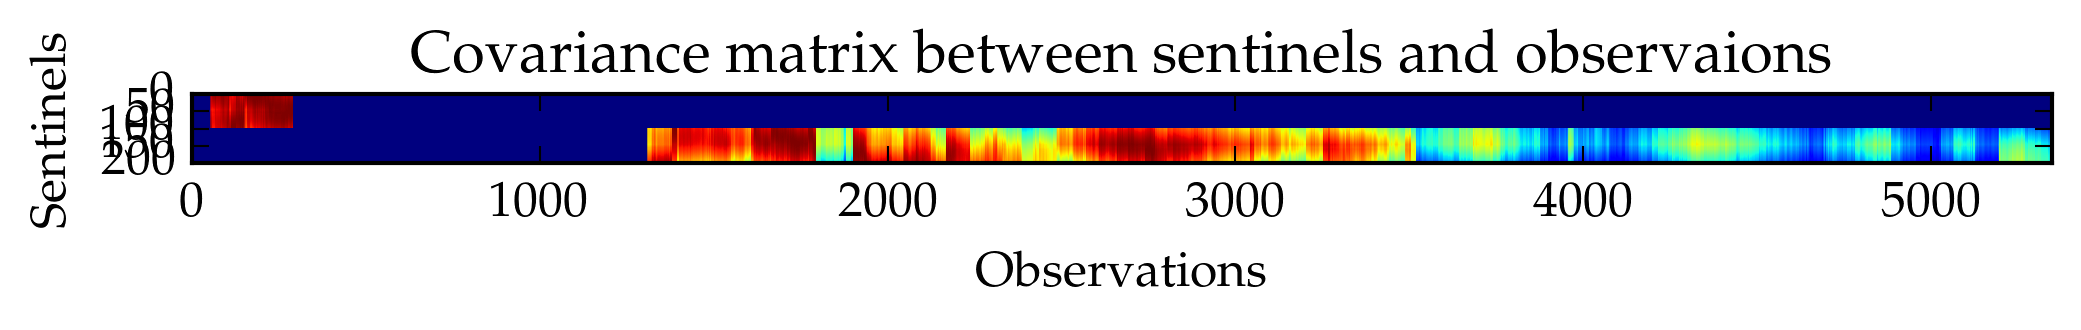

In [45]:
plt.imshow(cK_AB.^(1/100))
plt.title("Covariance matrix between sentinels and observaions")
plt.xlabel("Observations")
plt.ylabel("Sentinels")
;

In [46]:
Lck = PDMats.whiten(mgpcv.cK, cK_AB');

In [47]:
mu = [mean(mgpcv.m,X◫); mean(mgpcv.m,X◫)] + cK_AB*mgpcv.alpha;

In [48]:
Sigma_raw = cat([1,2], cov(mgpcv.k, X◫), cov(mgpcv.k, X◫)) - Lck'Lck;

In [49]:
μposterior = mu[1:n◫].-mu[n◫+1:2n◫]
Σposterior=Sigma_raw[1:n◫,1:n◫]+Sigma_raw[n◫+1:2n◫,n◫+1:2n◫]-Sigma_raw[1:n◫,n◫+1:2n◫]-Sigma_raw[n◫+1:2n◫,1:n◫]
;

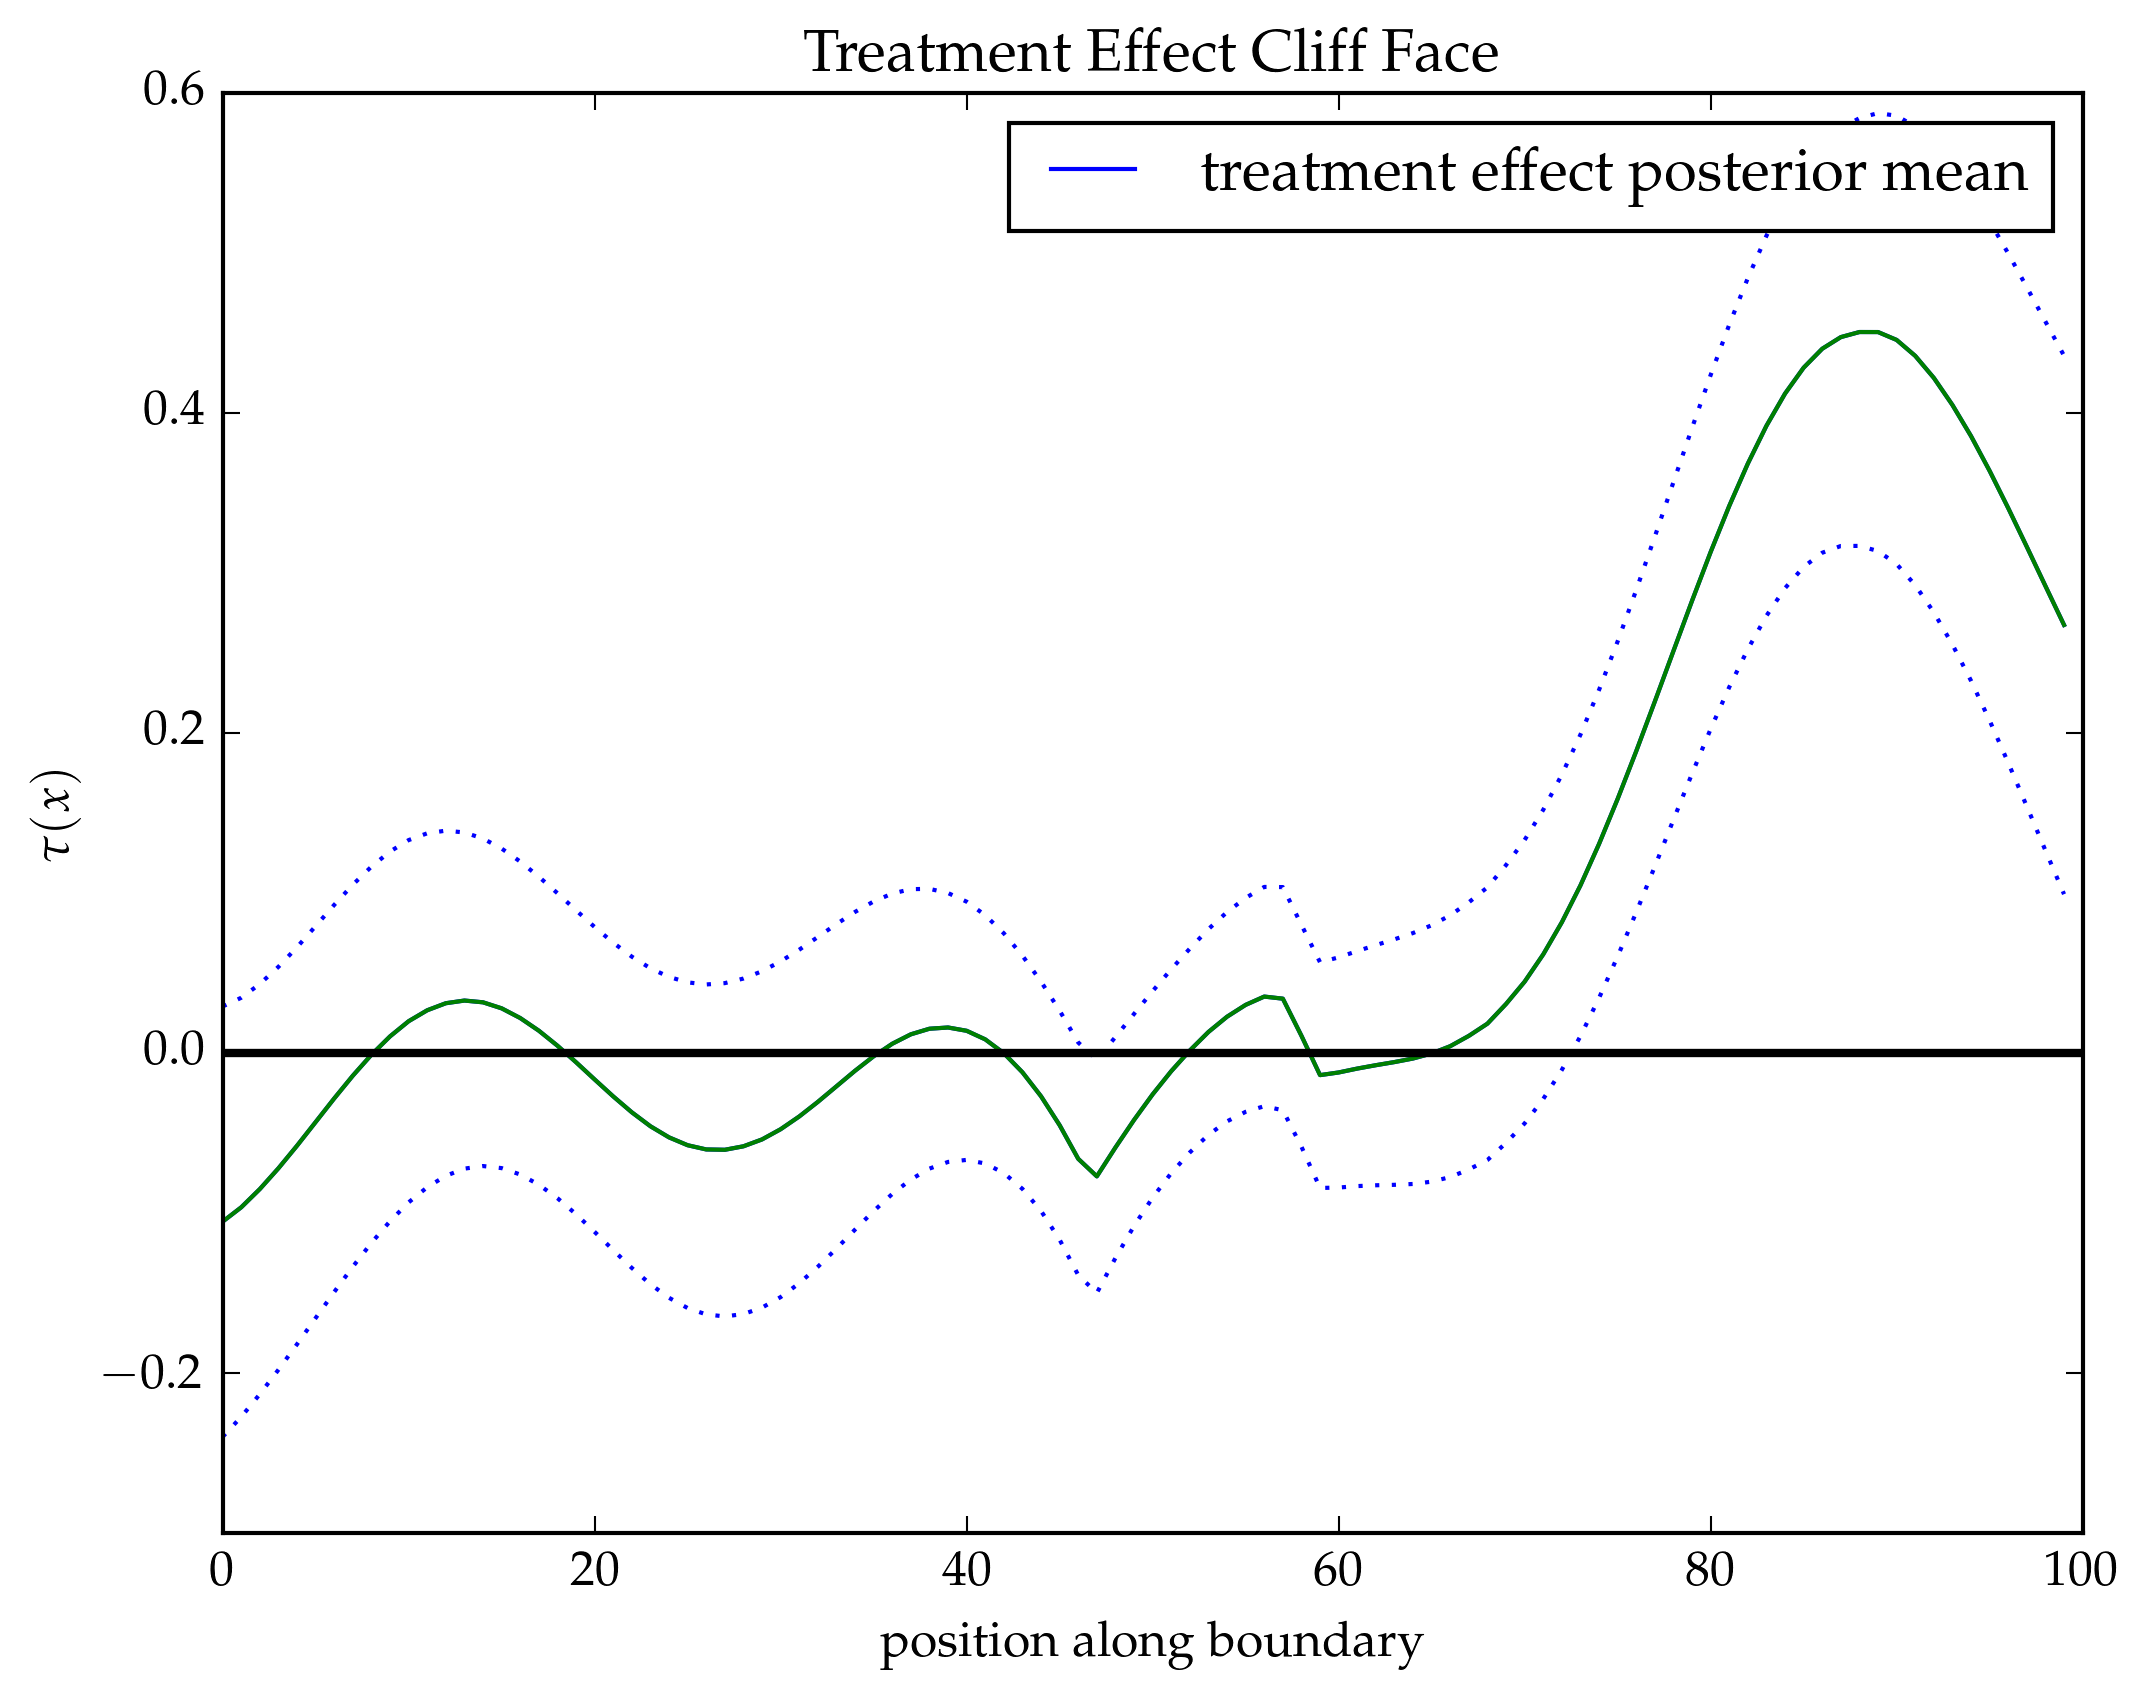

In [50]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(μposterior, color="blue", label="treatment effect posterior mean")
plt.plot(cK_AB[1:n◫,:]*mgpcv.alpha-cK_AB[n◫+1:end,:]*mgpcv.alpha, color="green")
plt.plot(μposterior.+√diag(Σposterior), color="blue", linestyle=":")
plt.plot(μposterior.-√diag(Σposterior), color="blue", linestyle=":")
plt.axhline(y=0, color="black", linewidth=2)
# plt.axhline(y=2, color="darkmagenta", label="truth")
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

In [51]:
denom_weighted = dot(ones(n◫),(Σposterior \ ones(n◫)))
τhat_weighted = sum(Σposterior\μposterior) / denom_weighted
Vτhat_weighted = 1/denom_weighted
Normal(τhat_weighted, √Vτhat_weighted)

Distributions.Normal{Float64}(μ=0.015620829733532036, σ=0.03897529575856585)

So the treatment effect cliff face shifts down, and the averaged treatment effect vanishes into insignificance. It's troubling that this made such a big difference to our inference. There are two possibilities worth exploring:

1. a bug in my code caused this
2. the change in hyperparameters caused this

The second hypothesis is easier to check, so let's start with that. We'll change the hyperparameters to what was fitted before integrating the linear regression in the $\gp$, and see if we recover similar results.

In [52]:
hyp = copy(opt_output.minimum)

5-element Array{Float64,1}:
 -1.80415
 11.9448 
  8.09091
 -1.75986
  1.22418

[Note: those parameters are (in order) logNoise, mean, $\log\mathscr{l}$, $\log\sigma_f$, -$\log\sigma_\beta$.]

In [53]:
previous_opt_output =  [-1.56556, 11.9455, 7.01038, -1.0029 ]

4-element Array{Float64,1}:
 -1.56556
 11.9455 
  7.01038
 -1.0029 

In [54]:
hyp[1:end-1] = previous_opt_output
set_params!(mgpcv, hyp)
update_mll!(mgpcv)

832.3360307817675

In [55]:
cK_A = cov(mgpcv.k, X◫, recent_X_dict[distrA]')
cK_B = cov(mgpcv.k, X◫, recent_X_dict[distrB]')
cK_AB = zeros(Float64, 2n◫, mgpcv.nobsv)
cK_AB[1:n◫,A_indices] = cK_A
cK_AB[n◫+1:2n◫,B_indices] = cK_B

Lck = PDMats.whiten(mgpcv.cK, cK_AB');
mu = [mean(mgpcv.m,X◫); mean(mgpcv.m,X◫)] + cK_AB*mgpcv.alpha;
Sigma_raw = cat([1,2], cov(mgpcv.k, X◫), cov(mgpcv.k, X◫)) - Lck'Lck;
μposterior = mu[1:n◫].-mu[n◫+1:2n◫]
Σposterior=Sigma_raw[1:n◫,1:n◫]+Sigma_raw[n◫+1:2n◫,n◫+1:2n◫]-Sigma_raw[1:n◫,n◫+1:2n◫]-Sigma_raw[n◫+1:2n◫,1:n◫]
;

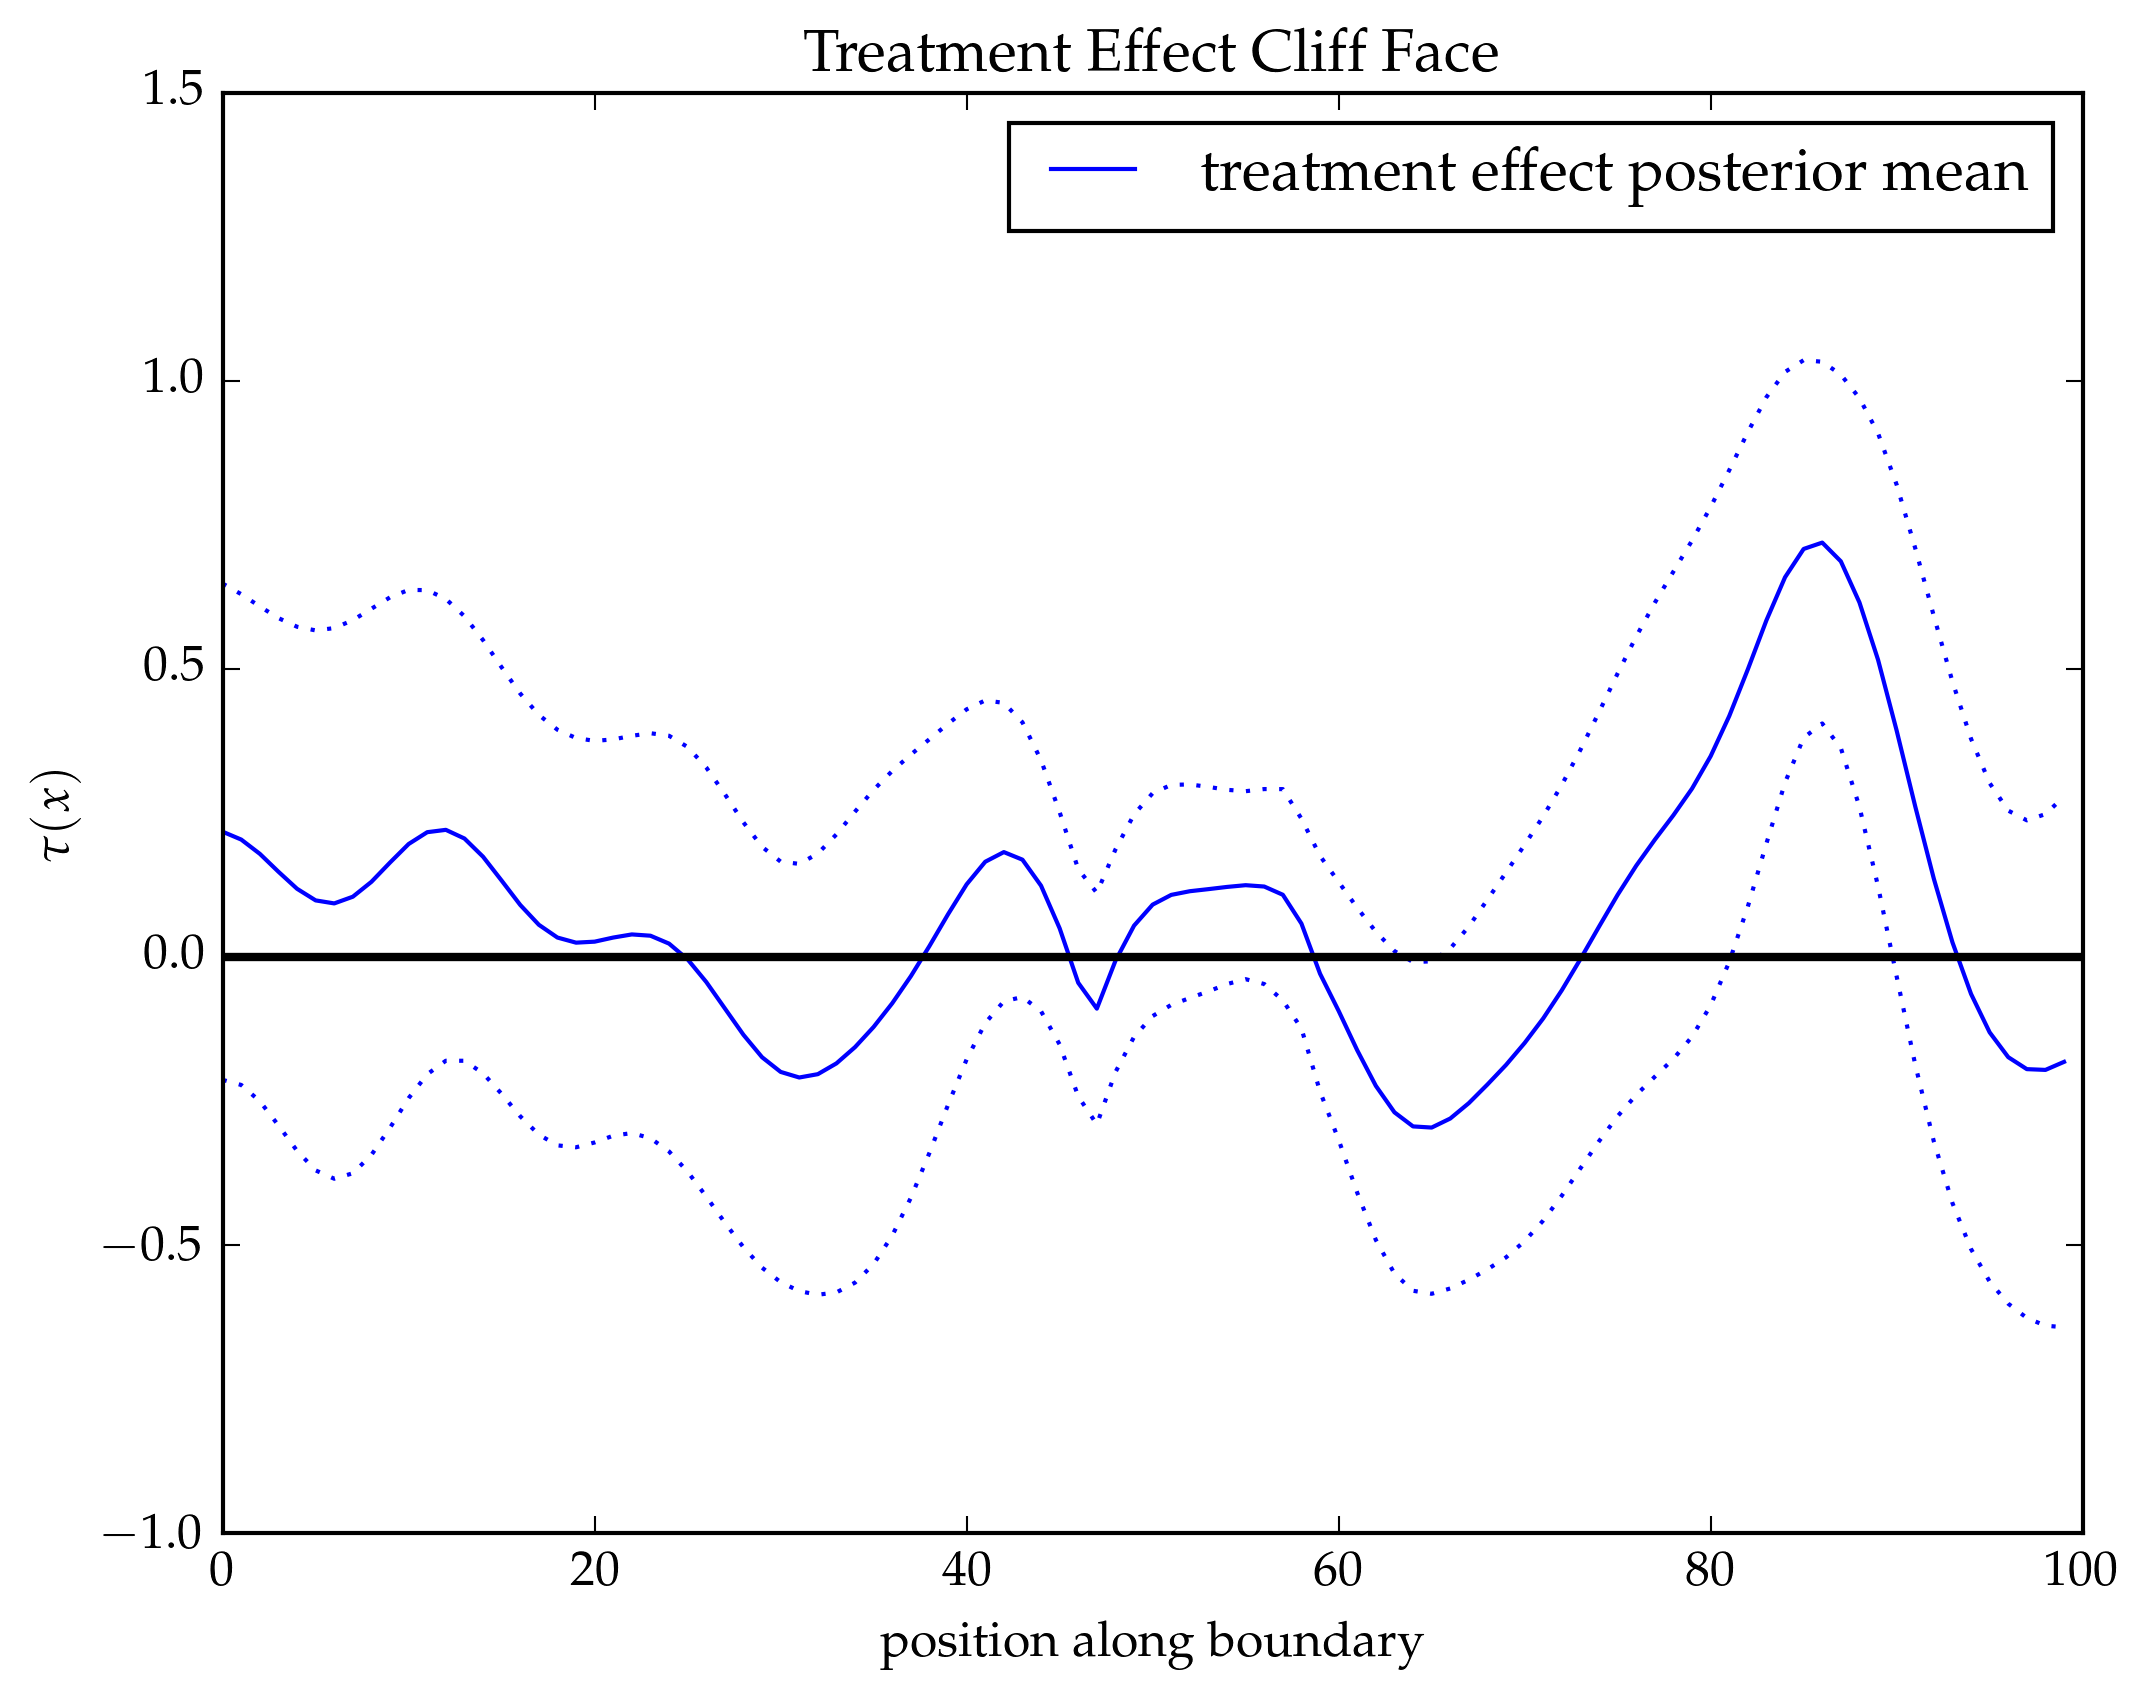

In [56]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(μposterior, color="blue", label="treatment effect posterior mean")
plt.plot(μposterior.+√diag(Σposterior), color="blue", linestyle=":")
plt.plot(μposterior.-√diag(Σposterior), color="blue", linestyle=":")
plt.axhline(y=0, color="black", linewidth=2)
# plt.axhline(y=2, color="darkmagenta", label="truth")
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

In [57]:
denom_weighted = dot(ones(n◫),(Σposterior \ ones(n◫)))
τhat_weighted = sum(Σposterior\μposterior) / denom_weighted
Vτhat_weighted = 1/denom_weighted
Normal(τhat_weighted, √Vτhat_weighted)

Distributions.Normal{Float64}(μ=0.04072445277335927, σ=0.07889008872584329)

In [59]:
set_params!(mgpcv, opt_output.minimum)
update_mll!(mgpcv)
;

There's a change in the cliff face, but we're still quite far off from what we had before, which is troubling.

# Debugging

## Constant shift

What if we shift all the data in school district A by a constant, do we then get a positive treatment effect?

In [61]:
recent_GP_dict_2=Dict{String, GP}()
σf = 0.2
σy = 0.1
L = 1000.0
for name in schdistrs
    X = recent_X_dict[name]
    Y = recent_Y_dict[name]
    if name == distrA
        Y .+= 1.0
    end
    if length(Y)==0
        println("no data for ", name)
        continue
    end
    fit = GP(X', Y, mgpcv.m, mgpcv.k, mgpcv.logNoise)
    recent_GP_dict_2[name] = fit
end
recent_multiGP_2 = GaussianProcesses.GP[recent_GP_dict_2[name] for name in schdistrs_have]
;

no data for Tanque Verde Unified District


In [65]:
mgpcv_2=MultiGPCovars(D_, recent_multiGP_2::MultiGP, mgpcv.βkern);
update_mll!(mgpcv_2)

1512.177787425212

In [167]:
cK_A = cov(mgpcv_2.k, X◫, recent_X_dict[distrA]')
cK_B = cov(mgpcv_2.k, X◫, recent_X_dict[distrB]')
cK_AB = zeros(Float64, 2n◫, mgpcv_2.nobsv)
cK_AB[1:n◫,A_indices] = cK_A
cK_AB[n◫+1:2n◫,B_indices] = cK_B
# Lck = PDMats.whiten(mgpcv_2.cK, cK_AB');
mu = [mean(mgpcv_2.m,X◫); mean(mgpcv_2.m,X◫)] + cK_AB*mgpcv_2.alpha;
Sigma_prior = cat([1,2], cov(mgpcv_2.k, X◫), cov(mgpcv_2.k, X◫))
# Sigma_raw = Sigma_prior - Lck'Lck
Sigma_raw = Sigma_prior - PDMats.Xt_invA_X(mgpcv_2.cK, cK_AB');
μposterior = mu[1:n◫].-mu[n◫+1:2n◫]
Σposterior=Sigma_raw[1:n◫,1:n◫]+Sigma_raw[n◫+1:2n◫,n◫+1:2n◫]-Sigma_raw[1:n◫,n◫+1:2n◫]-Sigma_raw[n◫+1:2n◫,1:n◫]
;

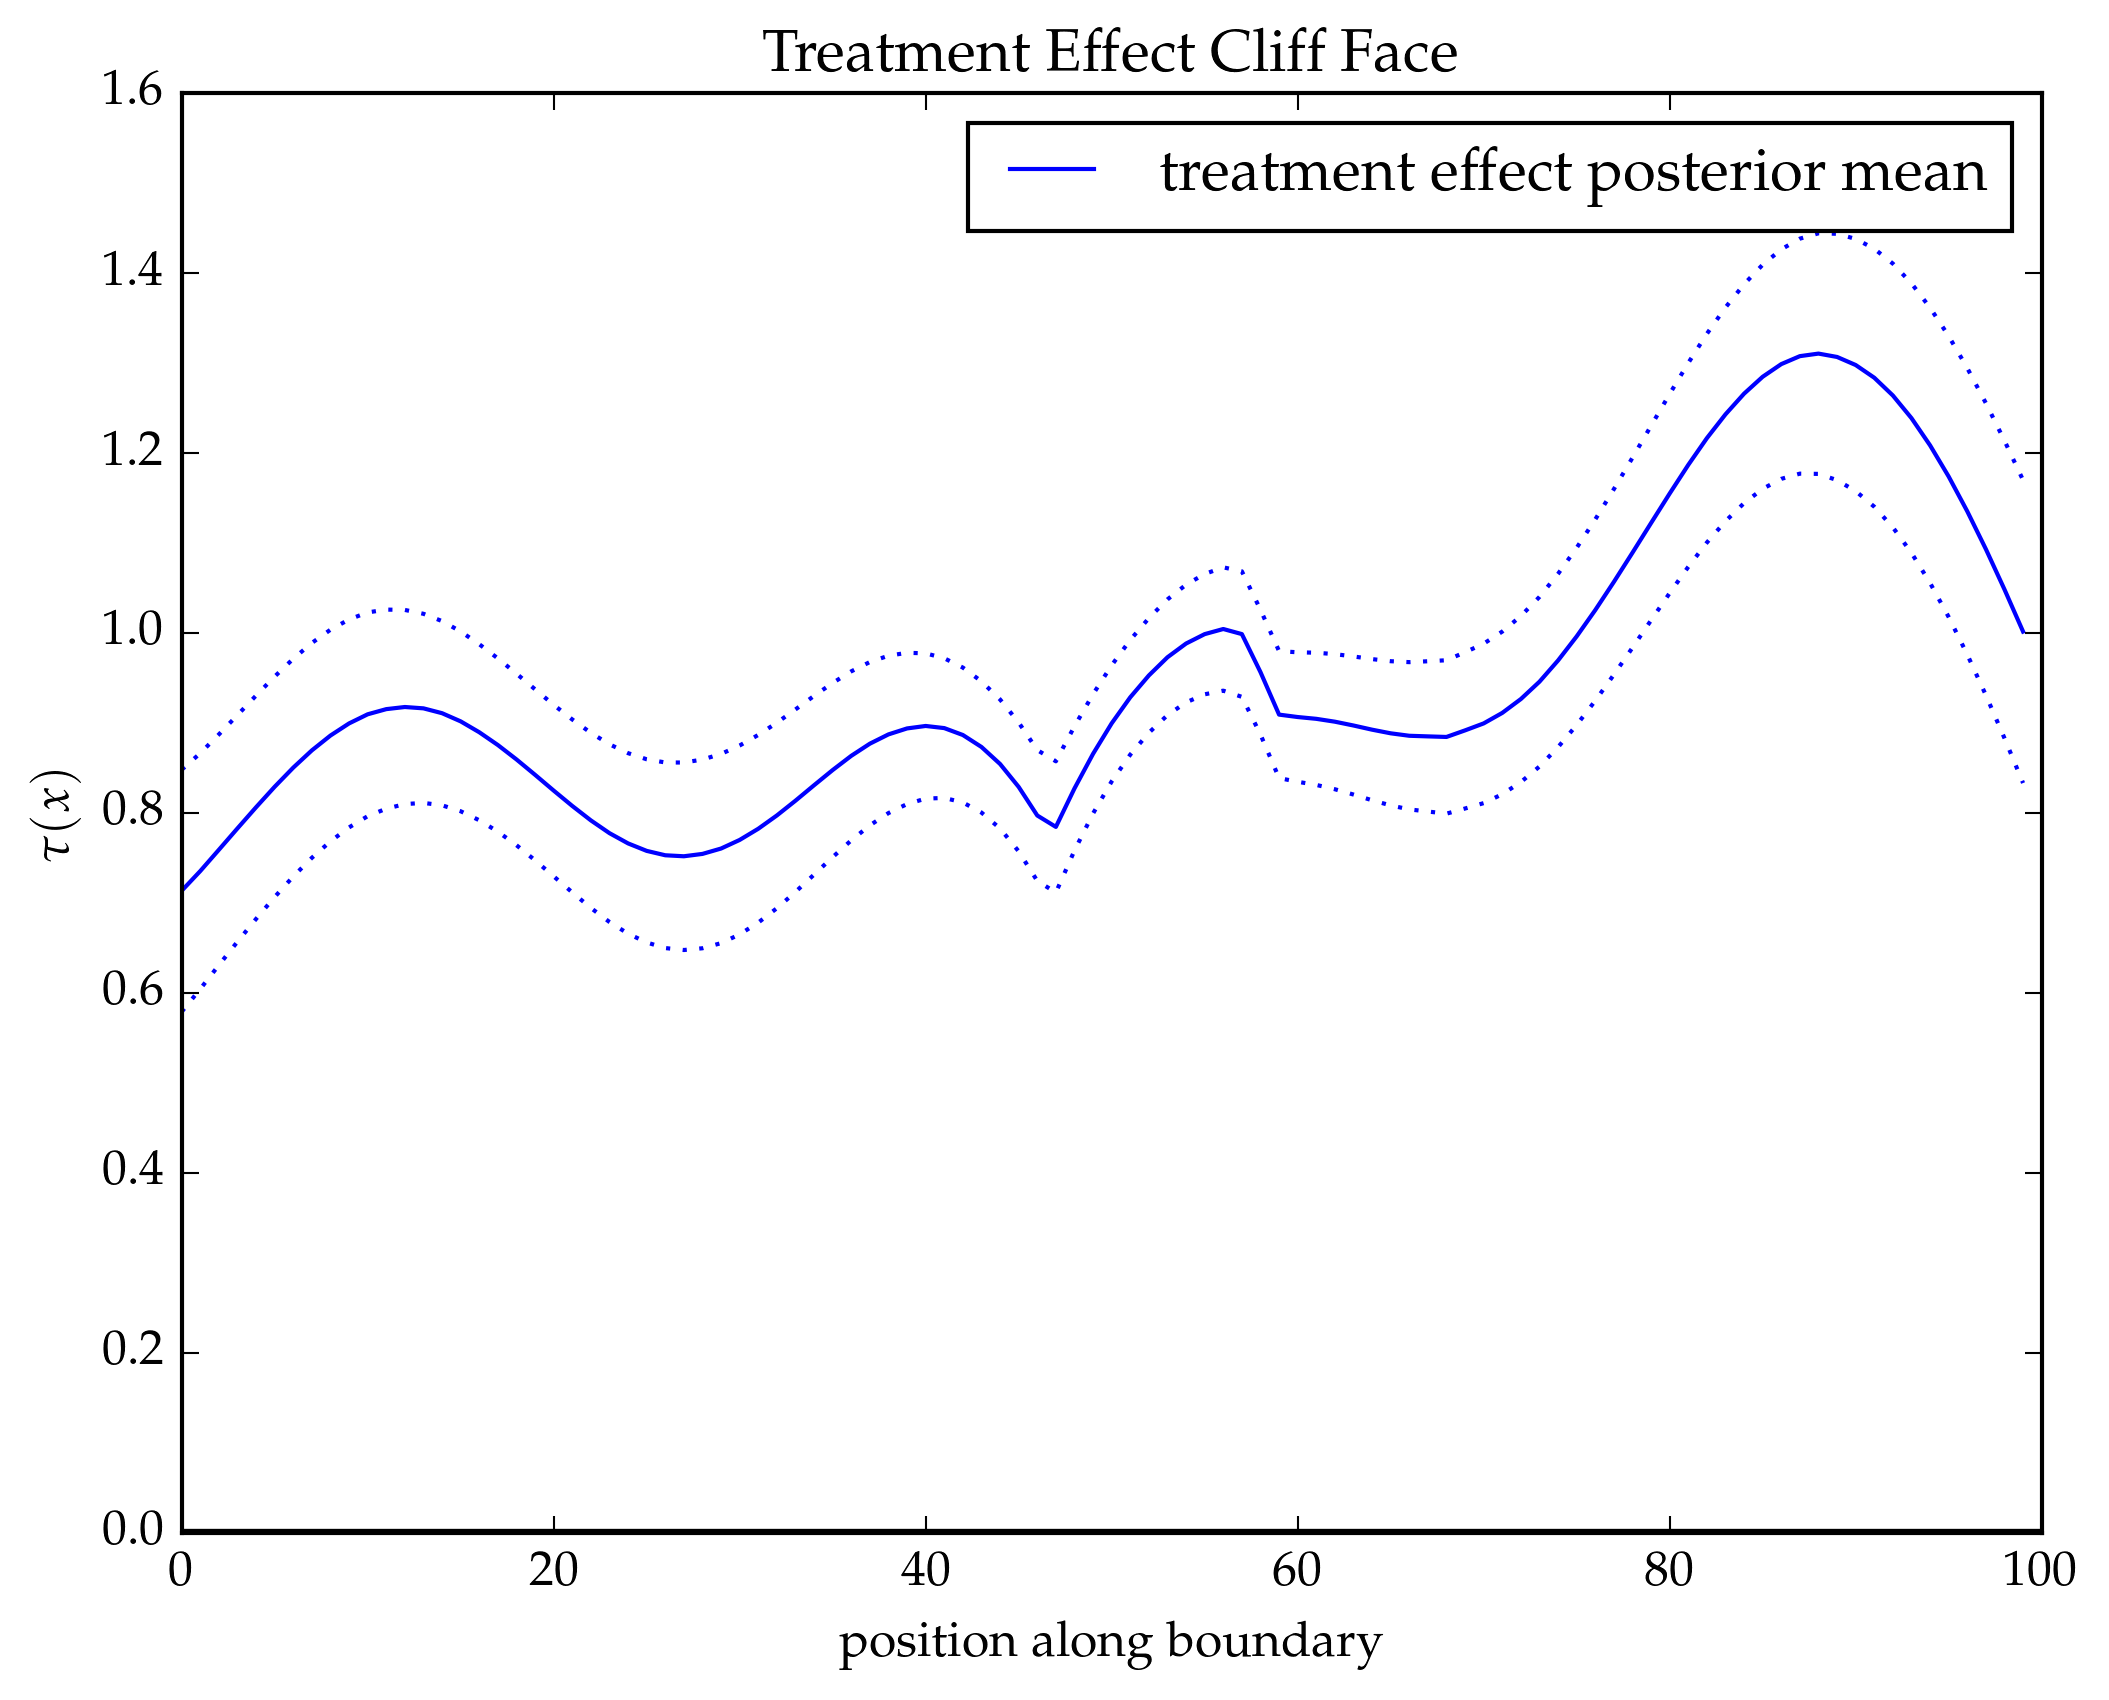

In [169]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(μposterior, color="blue", label="treatment effect posterior mean")
plt.plot(μposterior.+√diag(Σposterior), color="blue", linestyle=":")
plt.plot(μposterior.-√diag(Σposterior), color="blue", linestyle=":")
plt.axhline(y=0, color="black", linewidth=2)
# plt.axhline(y=2, color="darkmagenta", label="truth")
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

In [170]:
denom_weighted = dot(ones(n◫),(Σposterior \ ones(n◫)))
τhat_weighted = sum(Σposterior\μposterior) / denom_weighted
Vτhat_weighted = 1/denom_weighted
Normal(τhat_weighted, √Vτhat_weighted)

Distributions.Normal{Float64}(μ=0.8322034511934341, σ=0.03897529575856585)

So, yes, the treatment effect is picked up, though it is underestimated. Hmm...

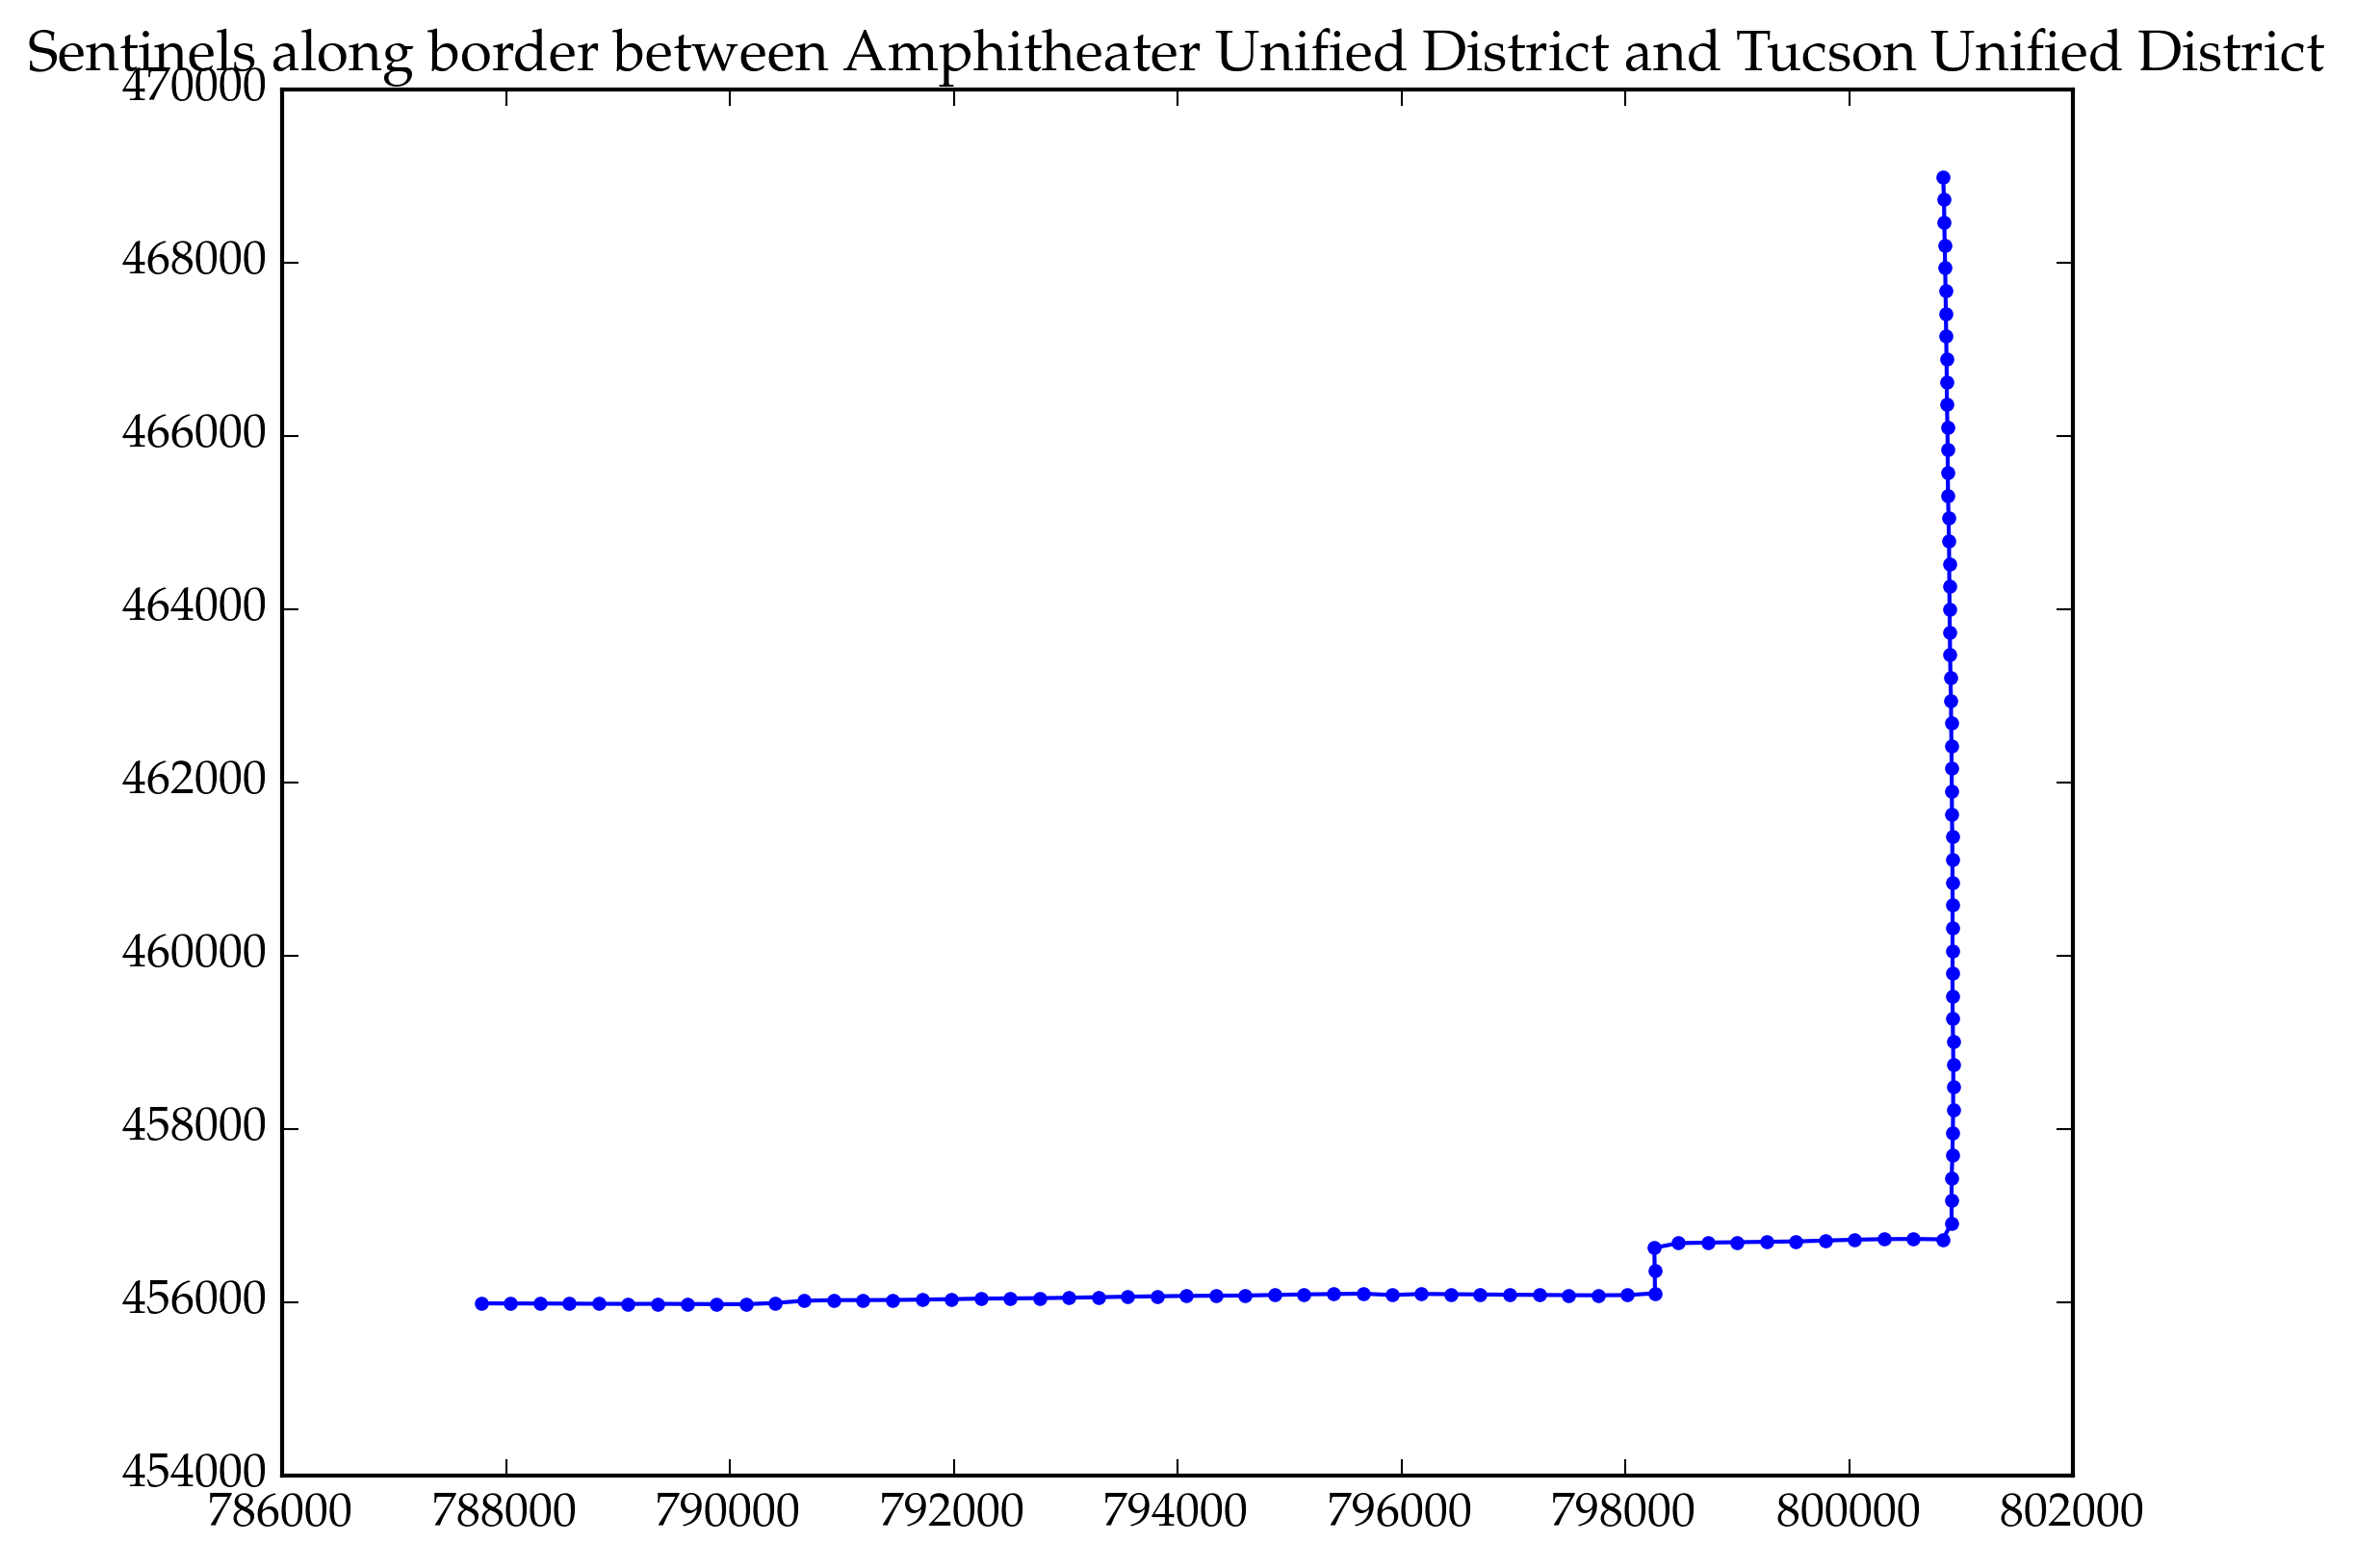

In [91]:
plt.plot(X◫[1,:],X◫[2,:], ".-")
plt.title(@sprintf("Sentinels along border between %s and %s", distrA, distrB))
;

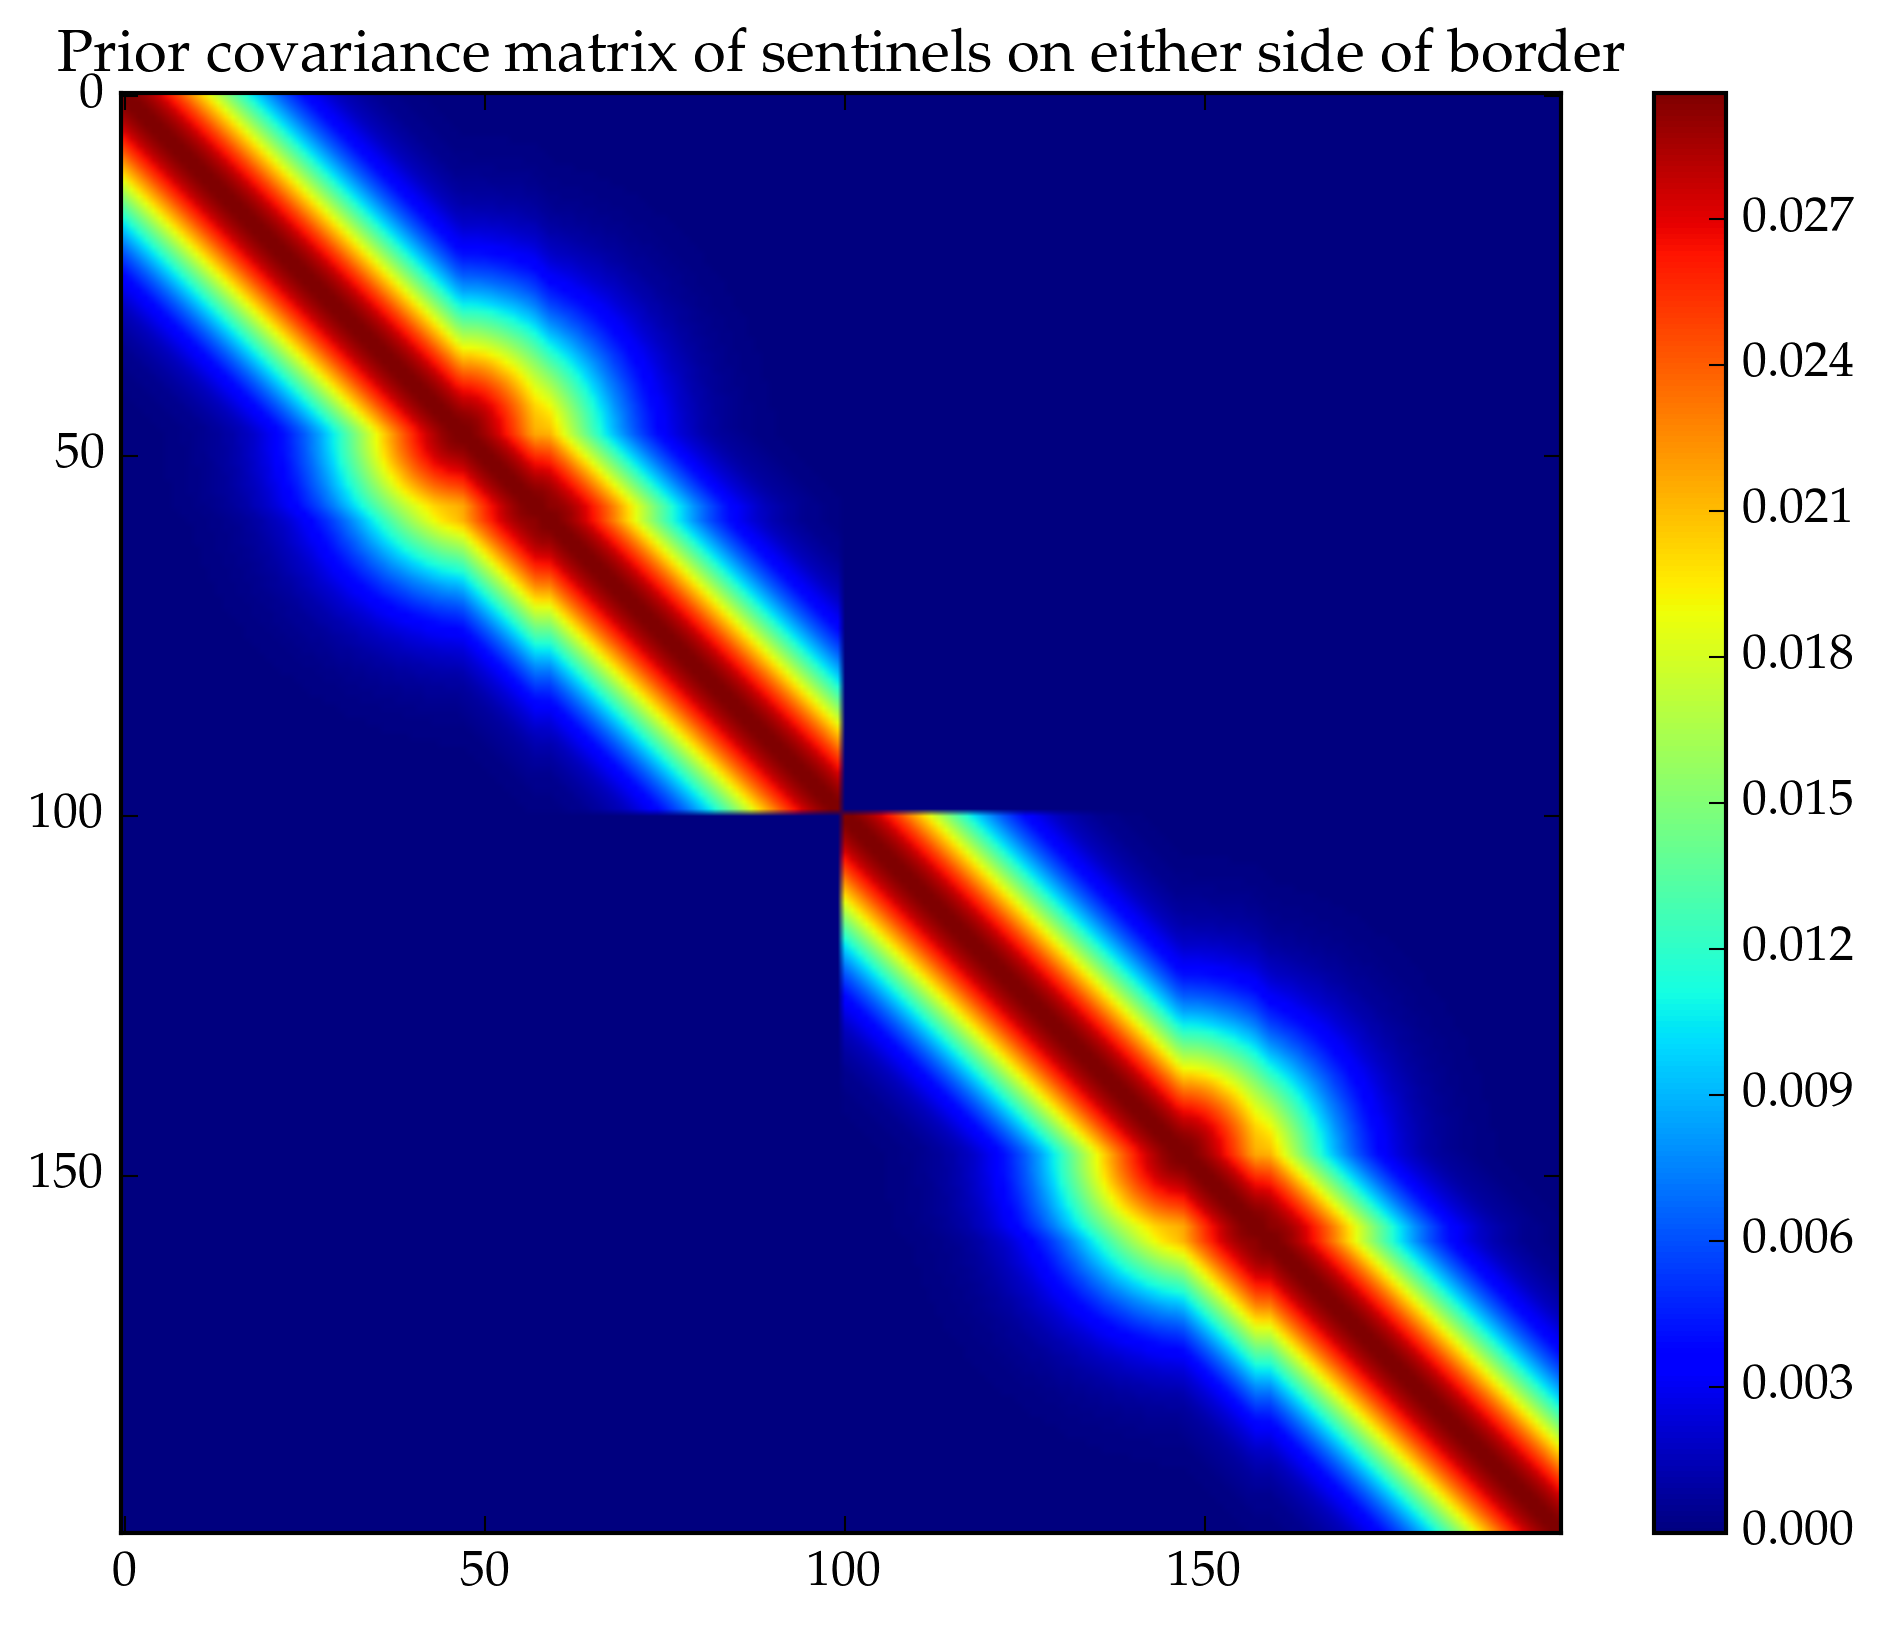

In [96]:
plt.imshow(Sigma_prior)
plt.colorbar()
plt.title("Prior covariance matrix of sentinels on either side of border")
;